In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
 
#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', values_format="d", colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, values_format=".2f", colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [3]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [4]:
# Load Data
multi_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR_I2xiiboTvyDr5-Cvvo_m7tnoT2tVnzOWUYf2xBZEhTWiWtZOyerF3c2aQeym10S8T2yHnTPnlPi2/pub?output=csv'
df_multi = pd.read_csv(multi_url)
df_multi.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [5]:
# Check for duplicates and missing data
print(df_multi.info())
print(f'{df_multi.duplicated().sum()} duplicate rows')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  155 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  157 non-null    float64
 3   Length2  157 non-null    float64
 4   Length3  150 non-null    float64
 5   Height   156 non-null    float64
 6   Width    157 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB
None
0 duplicate rows


In [6]:
# count rows with missing values
na_rows = df_multi.isna().any(axis=1).sum()
print(f'{na_rows} rows are missing data')
print(f'{na_rows/len(df_multi)*100:.1f}% of rows are missing data')

20 rows are missing data
12.6% of rows are missing data


In [7]:
# drop missing data
df_multi.dropna(inplace=True)
print(df_multi.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 157
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  139 non-null    object 
 1   Weight   139 non-null    float64
 2   Length1  139 non-null    float64
 3   Length2  139 non-null    float64
 4   Length3  139 non-null    float64
 5   Height   139 non-null    float64
 6   Width    139 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.7+ KB
None


In [8]:
# check class balance
df_multi['Species'].value_counts()

Perch        48
Bream        30
Roach        16
Pike         13
Smelt        13
Parkki       11
Whitefish     6
Beam          2
Name: Species, dtype: int64

In [9]:
df_multi['Species'].replace('Beam', 'Bream', inplace=True)

In [10]:
# split data
X = df_multi.drop(columns='Species')
y = df_multi['Species']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y)

In [11]:
# scale data
scaler = StandardScaler()
 
X_train_tf = scaler.fit_transform(X_train)
X_test_tf = scaler.transform(X_test)

In [12]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
# encode labels
encoder = LabelEncoder()
 
encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)
 
# make a record of the classes, in order of the encoding, in case we want to 
# translate predictions into fish names later.
classes = encoder.classes_
 
# binarize labels
binarizer = LabelBinarizer()
 
binarizer.fit(y_train_enc)
y_train_bin = binarizer.transform(y_train_enc)
y_test_bin = binarizer.transform(y_test_enc)
 
# check results
print('Original Target')
print(y_train.head())
 
print('\nEncoded Target')
print(y_train_enc[:5])
 
print('\nBinarized Target')
print(y_train_bin[:5])

Original Target
36     Roach
27     Bream
126    Perch
73     Perch
34     Bream
Name: Species, dtype: object

Encoded Target
[4 0 2 2 0]

Binarized Target
[[0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]]


In [13]:
# Define input shape
input_shape = X_train_tf.shape[1]
input_shape

6

In [14]:
# Define number of classes
num_classes = len(classes)
num_classes

7

In [15]:
# Build multiclass classification model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(50, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(50, 
                activation = 'relu'))
    model.add(Dropout(.2))
    #Output layer
    model.add(Dense(num_classes, activation = 'softmax'))
   
    
    # Compile Model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [16]:
# Call our build function to build model
multi_model = build_model()

# Get model summary
multi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                350       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 3,257
Trainable params: 3,257
Non-trainable params: 0
_________________________________________________________________


In [17]:
# fit model
history = multi_model.fit(X_train_tf, y_train_bin,
                          validation_split = .2,
                          epochs=100,
                          verbose=0)

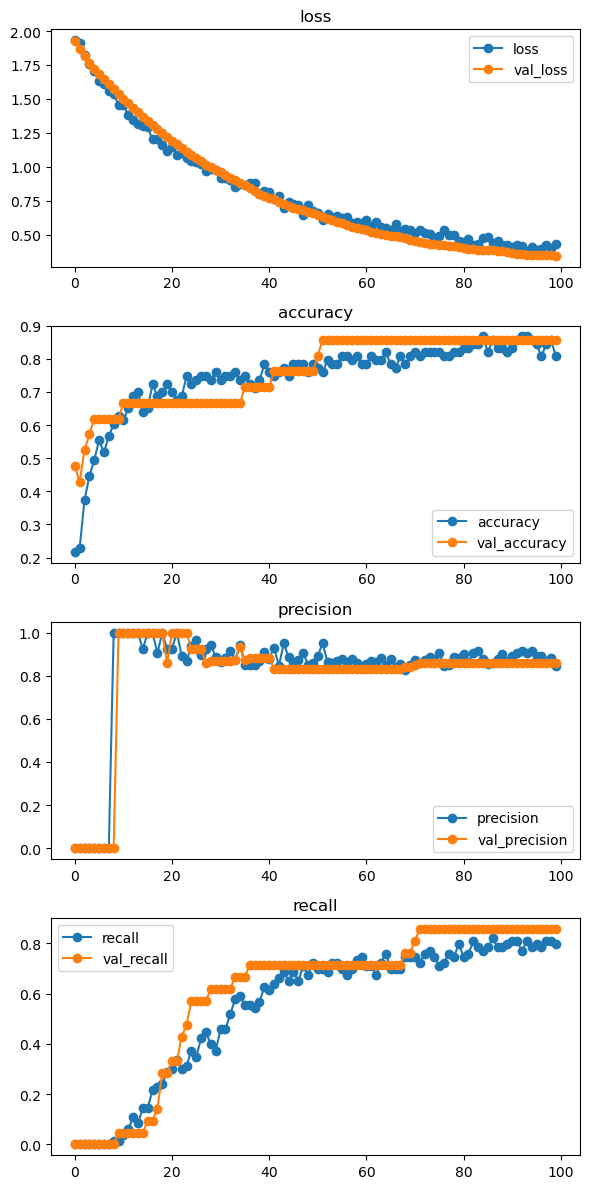

In [18]:
# plot learning history
plot_history(history);

In [19]:
# get raw predictions
raw_pred = multi_model.predict(X_test_tf)
 
# display predictions and binarized true labels
print('Raw Predictions\n', raw_pred[:5])
print('\nbinarized y_test\n', y_test_bin[:5])

2/2 [==============================] - 0s 3ms/step
Raw Predictions
 [[2.9049257e-03 1.6265942e-04 9.5369738e-01 8.1902193e-03 3.7080227e-04
  1.7667396e-04 3.4497388e-02]
 [1.1359430e-02 4.8108730e-02 4.9384156e-01 5.7238261e-03 3.4834221e-01
  2.8384678e-02 6.4239644e-02]
 [9.1958413e-04 2.7439930e-02 5.1307702e-01 4.0236881e-04 2.8671455e-01
  1.6227403e-01 9.1724824e-03]
 [5.6555446e-02 2.9000624e-03 8.0528182e-01 2.9419102e-02 2.7466537e-03
  1.7096152e-03 1.0138733e-01]
 [9.9333584e-01 4.6001566e-03 6.2151556e-04 3.6002442e-04 3.3010647e-04
  1.6983385e-04 5.8252027e-04]]

binarized y_test
 [[0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0]]


In [20]:
# convert predictions and labels into integers representing each fish class.
y_pred = np.argmax(raw_pred, axis=1)
y_true = np.argmax(y_test_bin, axis=1)
 
print('integer predictions', y_pred)
print('integer true labels', y_true)

integer predictions [2 2 2 2 0 2 5 3 2 0 2 0 3 2 0 2 2 2 2 0 1 3 0 5 2 2 5 0 0 1 2 0 2 2 2]
integer true labels [2 2 2 6 0 2 5 3 2 0 2 0 3 2 0 4 2 2 4 0 1 3 1 4 4 2 5 0 0 1 6 0 5 2 2]


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.67      0.80         3
           2       0.67      1.00      0.80        12
           3       1.00      1.00      1.00         3
           4       0.00      0.00      0.00         4
           5       0.67      0.67      0.67         3
           6       0.00      0.00      0.00         2

    accuracy                           0.77        35
   macro avg       0.60      0.62      0.60        35
weighted avg       0.66      0.77      0.70        35



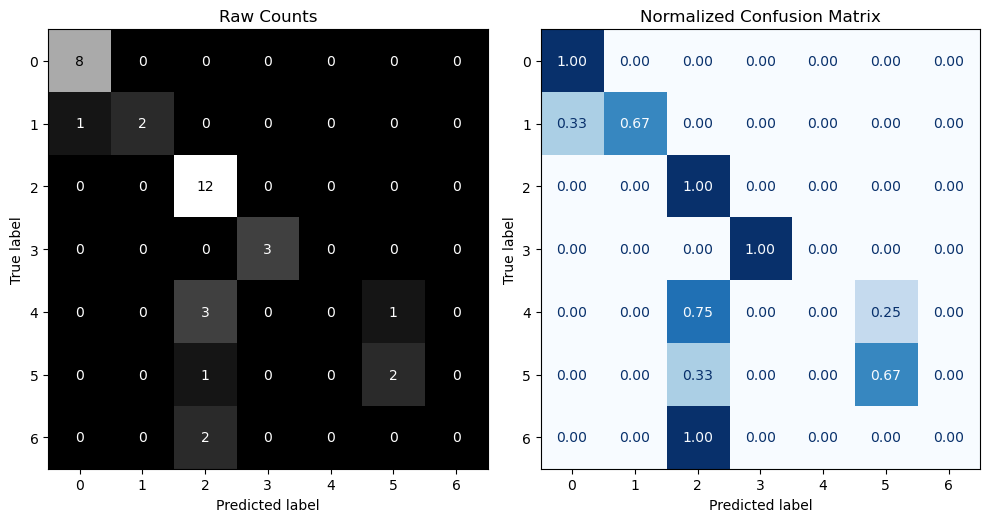

In [21]:
# Getting Sklearn Metrics
classification_metrics(y_true, y_pred, label='Test Data', figsize=(10,8))